# Load ALL the data in the database. Requires > 20 GB of RAM!!!!

In [10]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import datetime 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [107]:


# read password and user to database
credentials_file = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'

credentials = pd.read_csv(credentials_file, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


host="twofast-RPi3-0"  # your host
user=user  # username
passwd=pw  # password
db="NG_twofast_DB" # name of the database
connect_string = 'mysql+pymysql://%(user)s:%(pw)s@%(host)s/%(db)s'% {"user": user, "pw": pw, "host": host, "db": db}
sql_engine = sql.create_engine(connect_string)

def readDoseOverTime(sql_engine, startTime): 
	"""
	Read the flow meter voltage read from the database
	"""
	query = "SELECT * FROM data_dose WHERE time > %(t)s ORDER BY id DESC" % {"t": startTime}
	df = pd.read_sql(query, sql_engine)

	return df

def readHVOverTime(sql_engine, startTime):
	"""
	Read the flow meter voltage read from the database
	"""
	query = "SELECT * FROM data_HV WHERE time > %(t)s ORDER BY id DESC" % {"t": startTime}
	df = pd.read_sql(query, sql_engine)

	return df

def extract_day(row):
    day = row.day
    month = row.month
    year = row.year
#     print(f'{year}-{month}-{day}')
    return f'{year}-{month}-{day}'

def remove_nonsense_days(df, threshold):
    """
    Remove nonsense days from the dataframe. A nonsense day is one where the HV voltage entry was not above -50 kV.
    """
    max_voltage = df['HV_voltage'].max()
    day = df['day'].unique()[0]
    print(day, max_voltage)
#     print(max_voltage)
    if max_voltage >= threshold:
        return df
    else:
        pass

## Dose

In [320]:
df_dose_sample = df_dose.iloc[0:100000,:]
df_dose_sample.head()

,id,time,dose,dose_voltage,dose_corrected
3906395,1,2017-11-29 07:50:06.630523,16.3636,NaN,NaN
3906394,2,2017-11-29 07:50:07.622025,16.3636,NaN,NaN
3906393,3,2017-11-29 07:50:08.629873,16.3636,NaN,NaN
3906392,4,2017-11-29 07:50:09.641404,16.3636,NaN,NaN
3906391,5,2017-11-29 07:50:10.649331,16.3636,NaN,NaN


In [2]:
startTime = "2017-01-01"
df_dose = readDoseOverTime(sql_engine, startTime)
df_dose.to_csv('/Users/hkromer/02_PhD/tmp/df_dose.csv')

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Incorrect datetime value: '2015'")
  result = self._query(query)


In [300]:
df_dose = pd.read_csv('/Users/hkromer/02_PhD/tmp/df_dose.csv', index_col=0)

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [319]:
df_dose = df_dose.iloc[::-1]
# df_dose['time'] = pd.to_datetime(df_dose['time'])
# df_dose.head()

## HV

In [10]:
startTime = "2017-01-01"
df_hv = readHVOverTime(sql_engine, startTime)
df_hv.to_csv('/Users/hkromer/02_PhD/tmp/df_hv.csv')

In [26]:
# df_hv = df_hv.iloc[::-1]
# df_hv.set_index('time', inplace=True)
df_hv.loc['2019-07-12'].max()

id            5.253611e+06
HV_voltage    8.125000e+01
HV_current    1.493440e+00
dtype: float64

In [29]:
# df_hv = pd.read_csv('/Users/hkromer/02_PhD/tmp/df_hv.csv', index_col=0)
# df_hv = df_hv.iloc[::-1]
# df_hv.set_index('time', inplace=True)
# df_hv.reset_index(inplace=True)

# df_hv['time'] = pd.to_datetime(df_hv['time'])
# df_hv.set_index('time', inplace=True)


df_hv_sample = df_hv.iloc[0:100000,:]

In [30]:
df_hv_sample.head()

,time,id,HV_voltage,HV_current
0,2017-11-29 07:50:06.630523,1,0.15,0.0
1,2017-11-29 07:50:07.622025,2,0.15,0.0
2,2017-11-29 07:50:08.629873,3,0.15,0.0
3,2017-11-29 07:50:09.641404,4,0.15,0.0
4,2017-11-29 07:50:10.649331,5,0.15,0.0


In [37]:
# extract the day
df_hv_sample['day'] = df_hv_sample['time'].apply(lambda x: extract_day(x))
df_hv_sample.head()

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,id,HV_voltage,HV_current,day
0,2017-11-29 07:50:06.630523,1,0.15,0.0,2017-11-29
1,2017-11-29 07:50:07.622025,2,0.15,0.0,2017-11-29
2,2017-11-29 07:50:08.629873,3,0.15,0.0,2017-11-29
3,2017-11-29 07:50:09.641404,4,0.15,0.0,2017-11-29
4,2017-11-29 07:50:10.649331,5,0.15,0.0,2017-11-29


d

In [68]:
threshold = 50
a = df_hv_sample.groupby(['day'], as_index=False).apply(lambda x: remove_nonsense_days(x, threshold))
a = a.dropna(how='all')
len(a)

2017-11-29 40.37
2017-11-29 40.37
2017-12-1 100.4
2017-12-5 108.5
2017-12-7 101.45


71921

In [69]:
a['day'].unique()

array(['2017-12-1', '2017-12-5', '2017-12-7'], dtype=object)

### Drop all days that have HV voltage entries below the threshold

- threshold is chosen as 50 kV

In [87]:
threshold = 50
df_hv['day'] = df_hv['time'].apply(lambda x: extract_day(x))
a = df_hv.groupby(['day'], as_index=False).apply(lambda x: remove_nonsense_days(x, threshold))
a = a.dropna(how='all')
df_hv = a
df_hv.to_csv('/Users/hkromer/02_PhD/tmp/df_hv_nonsense_days_removed.csv')

2017-11-29 40.37
2017-11-29 40.37
2017-12-1 100.4
2017-12-20 101.3
2017-12-21 91.25
2017-12-5 108.5
2017-12-7 101.45
2018-10-1 80.0
2018-10-10 80.3125
2018-10-11 80.0
2018-10-12 80.0
2018-10-17 80.0
2018-10-18 80.0
2018-10-19 80.0
2018-10-2 80.3125
2018-10-20 80.0
2018-10-22 80.3125
2018-10-23 80.0
2018-10-24 80.0
2018-10-25 80.0
2018-10-29 80.0
2018-10-3 80.625
2018-10-30 80.3125
2018-10-31 80.3125
2018-10-4 80.625
2018-10-5 80.3125
2018-10-8 80.3125
2018-10-9 80.0
2018-11-12 80.625
2018-11-13 80.625
2018-11-14 90.1515
2018-11-15 90.1515
2018-11-16 100.0
2018-11-19 81.25
2018-11-2 81.5625
2018-11-20 80.3125
2018-11-21 80.625
2018-11-22 80.625
2018-11-23 80.625
2018-11-26 80.625
2018-11-27 80.625
2018-11-28 80.3125
2018-11-29 80.3125
2018-11-30 80.3125
2018-11-6 81.25
2018-11-7 90.1515
2018-11-8 80.3125
2018-11-9 80.9375
2018-12-1 80.3125
2018-12-10 81.25
2018-12-11 90.7576
2018-12-12 80.3125
2018-12-13 80.3125
2018-12-14 80.0
2018-12-15 81.25
2018-12-16 81.25
2018-12-17 81.25
2018-12-

### Resample to have data every 10 seconds

In [294]:
# df_hv.set_index('time', inplace=True)
# df_hv.reset_index(inplace=True)
df_hv.head()

,index,id,HV_voltage,HV_current,day
time,,,,,
2017-12-01 08:18:54.591255,0,28080.0,1.35,0.02,2017-12-1
2017-12-01 08:18:54.591255,1,28081.0,1.35,0.02,2017-12-1
2017-12-01 08:18:54.591255,2,28082.0,1.35,0.02,2017-12-1
2017-12-01 08:18:54.591255,3,28083.0,1.35,0.02,2017-12-1
2017-12-01 08:18:54.591255,4,28084.0,0.15,0.00,2017-12-1


In [289]:
df_hv_sample.head()

,id,HV_voltage,HV_current,day
time,,,,
2017-11-29 07:50:06.630523,1,0.15,0.0,2017-11-29
2017-11-29 07:50:07.622025,2,0.15,0.0,2017-11-29
2017-11-29 07:50:08.629873,3,0.15,0.0,2017-11-29
2017-11-29 07:50:09.641404,4,0.15,0.0,2017-11-29
2017-11-29 07:50:10.649331,5,0.15,0.0,2017-11-29


In [99]:
# df_hv_sample.set_index('time', inplace=True)

In [321]:
def resample_10_seconds(df, cols):
    """
    Takes the grouped df (groupby day) and resample HV_voltage and HV_current in 10s
    """
    day = df['day'].unique()[0]   
    d = {}
    range_start = f'{day} 00:00'
    range_end = f'{day} 23:59'
    # resample 24 hours in steps of 10 s
    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()
#         df_out[col] = 0
    this_d = pd.DataFrame(d)
    
    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
#     df_out = df_out.drop(columns=['level_0', 'level_1'])
    return df_out

df_hv_resampled = df_hv.groupby(['day'], as_index=False).apply(lambda x: resample_10_seconds(x, ['HV_voltage', 'HV_current'])).reset_index()
df_hv_resampled.rename(columns={'key_0': 'time'}, inplace=True)
df_hv_resampled.drop(columns=['level_0', 'level_1'], inplace=True)
df_hv_resampled['day'] = df_hv_resampled['time'].apply(lambda x: extract_day(x))
df_hv_resampled.set_index('time', inplace=True)
df_hv_resampled.fillna(0, inplace=True)
df_hv_resampled.to_csv('/Users/hkromer/02_PhD/tmp/df_hv_nonsense_days_removed_resampled.csv')

### Go through the dose dataframe, drop those dates that have no HV data

In [335]:
df_dose = pd.read_csv('/Users/hkromer/02_PhD/tmp/df_dose.csv', index_col=0)
df_dose = df_dose.iloc[::-1]
df_dose['time'] = pd.to_datetime(df_dose['time'])
# df_dose.reset_index(inplace=True)
# df_dose.set_index('time', inplace=True)
df_dose.head()

,id,time,dose,dose_voltage,dose_corrected
3906395,1,2017-11-29 07:50:06.630523,16.3636,NaN,NaN
3906394,2,2017-11-29 07:50:07.622025,16.3636,NaN,NaN
3906393,3,2017-11-29 07:50:08.629873,16.3636,NaN,NaN
3906392,4,2017-11-29 07:50:09.641404,16.3636,NaN,NaN
3906391,5,2017-11-29 07:50:10.649331,16.3636,NaN,NaN


In [338]:
useful_days = df_hv_resampled['day'].unique().tolist()
print(useful_days)
def remove_nonsense_days_from_dose(df):
    """
    Remove nonsense days from the dataframe. A nonsense day is one where the HV voltage entry was not above -50 kV.
    """

    day = df['day'].unique()[0]

    if day in useful_days:
        return df
    else:
        pass

# get the day
# df_dose_sample.reset_index(inplace=True)
df_dose['day'] = df_dose['time'].apply(lambda x: extract_day(x))
df_dose = df_dose.dropna(how='all')
print(len(df_dose))
a = df_dose.groupby(['day']).apply(lambda x: remove_nonsense_days_from_dose(x))
df_dose = a.dropna(how='all')
print(len(df_dose))

['2017-12-1', '2017-12-20', '2017-12-21', '2017-12-5', '2017-12-7', '2018-10-1', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-2', '2018-10-20', '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25', '2018-10-29', '2018-10-3', '2018-10-30', '2018-10-31', '2018-10-4', '2018-10-5', '2018-10-8', '2018-10-9', '2018-11-12', '2018-11-13', '2018-11-14', '2018-11-15', '2018-11-16', '2018-11-19', '2018-11-2', '2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30', '2018-11-6', '2018-11-7', '2018-11-8', '2018-11-9', '2018-12-1', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-2', '2018-12-20', '2018-12-21', '2018-6-26', '2018-6-28', '2018-6-29', '2018-7-10', '2018-7-11', '2018-7-12', '2018-7-13', '2018-7-17', '2018-7-18', '2018-7-19', '2018-7-2', '2018-7-25', '2018-7-26', '2018-7-

In [340]:
df_dose.head()

,id,time,dose,dose_voltage,dose_corrected,day
3878316,28080.0,2017-12-01 08:18:50.773196,16.3636,NaN,NaN,2017-12-1
3878315,28081.0,2017-12-01 08:18:50.773196,16.3636,NaN,NaN,2017-12-1
3878314,28082.0,2017-12-01 08:18:50.773196,12.7273,NaN,NaN,2017-12-1
3878313,28083.0,2017-12-01 08:18:50.773196,12.7273,NaN,NaN,2017-12-1
3878312,28084.0,2017-12-01 08:18:50.773196,12.7273,NaN,NaN,2017-12-1


In [339]:
df_dose.to_csv('/Users/hkromer/02_PhD/tmp/df_dose_nonsense_days_removed.csv')

### Resample the remaining dose the same way as the HV

In [342]:
df_dose.set_index('time', inplace=True)
a = df_dose.groupby(['day'], as_index=False).apply(lambda x: resample_10_seconds(x, ['dose', 'dose_voltage', 'dose_corrected'])).reset_index()

a.rename(columns={'key_0': 'time'}, inplace=True)
a.drop(columns=['level_0', 'level_1'], inplace=True)
a['day'] = a['time'].apply(lambda x: extract_day(x))
a.set_index('time', inplace=True)
df_dose_resampled = a.fillna(0)
df_dose_resampled.to_csv('/Users/hkromer/02_PhD/tmp/df_dose_nonsense_days_removed_resampled.csv')

## Combine dose and hv

In [382]:
assert len(df_hv_resampled.day.unique()) == len(df_dose_resampled.day.unique())
df_out = df_hv_resampled.merge(df_dose_resampled, left_on=df_hv_resampled.index, right_on=df_dose_resampled.index, how='outer')
df_out = df_out.drop(columns = 'day_y')
df_out = df_out.rename(columns={'key_0': 'time', 'day_x': 'day'})
df_out.set_index('time', inplace=True)
df_out.to_csv('/Users/hkromer/02_PhD/tmp/df_COMBINED_nonsense_days_removed_resampled.csv')
df_out.head()

,HV_voltage,HV_current,day,dose,dose_voltage,dose_corrected
time,,,,,,
2017-12-01 00:00:00,0.0,0.0,2017-12-1,0.0,0.0,0.0
2017-12-01 00:00:10,0.0,0.0,2017-12-1,0.0,0.0,0.0
2017-12-01 00:00:20,0.0,0.0,2017-12-1,0.0,0.0,0.0
2017-12-01 00:00:30,0.0,0.0,2017-12-1,0.0,0.0,0.0
2017-12-01 00:00:40,0.0,0.0,2017-12-1,0.0,0.0,0.0


## Put all out in separate csv


In [386]:
outfolder = '/Users/hkromer/02_PhD/tmp/data_robert/'
def output_daily_data(df, outfolder):
    day = df['day'].unique()[0]
    print(f'Saving day {day}...')
    df.to_csv(f'{outfolder}/{day}.csv')
    
df_out.groupby(['day'], as_index=False).apply(lambda x: output_daily_data(x, outfolder)).reset_index()

Saving day 2017-12-1...
Saving day 2017-12-1...
Saving day 2017-12-20...
Saving day 2017-12-21...
Saving day 2017-12-5...
Saving day 2017-12-7...
Saving day 2018-10-1...
Saving day 2018-10-10...
Saving day 2018-10-11...
Saving day 2018-10-12...
Saving day 2018-10-17...
Saving day 2018-10-18...
Saving day 2018-10-19...
Saving day 2018-10-2...
Saving day 2018-10-20...
Saving day 2018-10-22...
Saving day 2018-10-23...
Saving day 2018-10-24...
Saving day 2018-10-25...
Saving day 2018-10-29...
Saving day 2018-10-3...
Saving day 2018-10-30...
Saving day 2018-10-31...
Saving day 2018-10-4...
Saving day 2018-10-5...
Saving day 2018-10-8...
Saving day 2018-10-9...
Saving day 2018-11-12...
Saving day 2018-11-13...
Saving day 2018-11-14...
Saving day 2018-11-15...
Saving day 2018-11-16...
Saving day 2018-11-19...
Saving day 2018-11-2...
Saving day 2018-11-20...
Saving day 2018-11-21...
Saving day 2018-11-22...
Saving day 2018-11-23...
Saving day 2018-11-26...
Saving day 2018-11-27...
Saving day 2

,index


# Include the output

- compute from the dose


In [1]:
# 02_PhD/01.github/phd/05_MCNP/02.output_determination/MCNP_neutron_output/fun_getNeutronOutputPer100muSv.py
import pandas as pd
import numpy as np
import os, glob
from shutil import copyfile
import re
import sys


# # copy the MCNP files
# lst_ID = np.arange(126,135,1)
# path = '//fs03//LTH_Neutimag//hkromer//10_Experiments//02_MCNP//'

# for ID in lst_ID:
# 	this_path = '{}CurrentTarget{}/CurrentTarget{}_normal/'.format(path, ID, ID)
# 	for fname in glob.glob('{}df_neutron_output_for_Edeut_*.csv'.format(this_path)):
# 		newfname = fname.replace('df_', 'df_ID{}_'.format(ID))
# 		_ = re.findall(r'(df.+)', newfname)
# 		if len(_)>0:
# 			newfname = _[0]
# 		newfname = '//fs03/LTH_Neutimag/hkromer/02_Simulations/01_Python/MCNP_neutron_output/MCNP_results_oldTarget/{}'.format(newfname)
# 		copyfile(fname, newfname)

def getNeutronOutputPer100muSv(HV=100, LB6411_distance=70, newTarget=1):
	"""
	Retrieves the neutron output per 100µSv/h as determined from MCNP. Only works for the new target. Returns that value
	HV: High voltage. This determines which MCNP run is taken to load the data. Default is -100 kV
	LB6411_distance: Distance between the source and LB6411 position. Default is 70 cm
	newTarget: if 1, then the files for the new target are used, 0 the files for the old target are used
	returns neutron output per 100 µSv/hr as read by the LB6411
	"""
	master_path = '/Users/hkromer/02_PhD/01.github/phd/05_MCNP/02.output_determination/MCNP_neutron_output/'
	if newTarget == 1:
		path_to_MCNP_OutputPer100muSv = '{}MCNP_results_newTarget/'.format(master_path)
	else:
		path_to_MCNP_OutputPer100muSv = '{}MCNP_results_oldTarget/'.format(master_path)


	# get which HVs have been simulated in MCNP
	lst_HV = []
	for fname in glob.glob('{}*.csv'.format(path_to_MCNP_OutputPer100muSv)):
		_ = re.findall(r'(\d+)\.csv', fname)
		lst_HV.append(int(_[0]))


	# list of the ID's for the respective MCNP simulation
	lst_ID = []
	for fname in glob.glob('{}*.csv'.format(path_to_MCNP_OutputPer100muSv)):
		_ = re.findall(r'ID(\d+)_', fname)
		lst_ID.append(int(_[0]))
	# print(lst_ID)
	# find index of the HV in the lst_HV
	try:
		idx = lst_HV.index(HV)
	except ValueError:
		idx = -1

	if idx == -1:
		print('--- Available high voltage settings: {}'.format(lst_HV))
		print('--- High voltage value of ' + str(HV) + ' is not in an MCNP run. sys.exit(). --- ')
		sys.exit()
	else:
		csv_name = '{}df_ID{}_neutron_output_for_Edeut_{}.csv'.format(path_to_MCNP_OutputPer100muSv, lst_ID[idx], lst_HV[idx])
		df = pd.read_csv(csv_name, header=0)

		distance = LB6411_distance

		neutronOutputPer100muSv = df.W[ df.distance == distance ].values
		# print(path_to_MCNP_OutputPer100muSv)

		return neutronOutputPer100muSv

# print(getNeutronOutputPer100muSv(HV=85, LB6411_distance=50, newTarget=0))

## Get a relation between muSv/hr and total neutron output for 50, 55, and 70 cm as position of the LB6411

- returns a df with rows as different distances, cols are the HV values and the values are the outputs in n/s per 100 muSv/hr

In [11]:
HVs = [105, 80, 95, 110, 100, 90, 85]
d = {}
for HV in HVs:
    d[HV] = getNeutronOutputPer100muSv(HV=HV, LB6411_distance=50, newTarget=1)[0]
s_50 = pd.Series(d)

d = {}
for HV in HVs:
    d[HV] = getNeutronOutputPer100muSv(HV=HV, LB6411_distance=55, newTarget=1)[0]
s_55 = pd.Series(d)

d = {}
for HV in HVs:
    d[HV] = getNeutronOutputPer100muSv(HV=HV, LB6411_distance=70, newTarget=1)[0]
s_70 = pd.Series(d)
df_relation = pd.DataFrame([s_50, s_55, s_70], index = ['50', '55', '70'])

df_relation.to_csv('/Users/hkromer/02_PhD/tmp/relation_dose_output.csv')
df_relation

,105,80,95,110,100,90,85
50,1.503027e+06,1.483221e+06,1.492692e+06,1.509825e+06,1.494960e+06,1.489923e+06,1.486985e+06
55,1.721242e+06,1.698678e+06,1.709469e+06,1.729081e+06,1.712045e+06,1.706365e+06,1.702974e+06
70,3.049418e+06,3.010704e+06,3.029237e+06,3.063890e+06,3.033565e+06,3.024469e+06,3.018164e+06


In [18]:
df_relation.loc['50'].sort_values().values

array([1483221.41318121, 1486985.03475818, 1489922.54654678,
       1492692.1842968 , 1494960.03243637, 1503027.01333572,
       1509824.81315359])

## Add to the dataframe the neutron output


In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# read the combined dataframe
df = pd.read_csv('/Users/hkromer/02_PhD/tmp/df_COMBINED_nonsense_days_removed_resampled.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [27]:
# dictionary with the position of the LB6411. Only 2017-12-1 the sphere was at 50 cm 
positions = {'2017-12-1': 50}
interp_50 = interp1d(df_relation.loc['50'].sort_values().index, df_relation.loc['50'].sort_values().values, kind='cubic', fill_value="extrapolate")
interp_70 = interp1d(df_relation.loc['70'].sort_values().index, df_relation.loc['70'].sort_values().values, kind='cubic', fill_value="extrapolate")


interpolation_output = {'50': interp_50, '70': interp_70}

def compute_neutron_output(row):
    HV = row['HV_voltage']
    day = row['day']
    distance = int(row['LB6411_distance'])
    dose = row['dose_corrected']
    
    # get the correct interpolation for HV at that distance of LB6411 sphere
    interp = interpolation_output[str(distance)]
    
    # conversion factor neutronOutputPer100muSv
    factor = (1/100) * interp(HV) 

    return factor * dose
    
df['LB6411_distance'] = df['day'].map(positions).fillna(70)
df['neutron_output'] = df.apply(lambda x: compute_neutron_output(x), axis=1)

In [32]:
df.columns

Index(['HV_voltage', 'HV_current', 'day', 'dose', 'dose_voltage',
       'dose_corrected', 'LB6411_distance', 'neutron_output'],
      dtype='object')

## Save to csv for Robert

In [33]:
df.to_csv('/Users/hkromer/02_PhD/tmp/df_with_neutron_output.csv')

outfolder = '/Users/hkromer/02_PhD/tmp/data_robert/'
cols= ['HV_voltage', 'HV_current', 'dose_corrected', 'neutron_output'] # cols to save

def output_daily_data(df, outfolder, cols):
    day = df['day'].unique()[0]
    print(f'Saving day {day}...')
    df[cols].to_csv(f'{outfolder}/{day}.csv')
    
df.groupby(['day'], as_index=False).apply(lambda x: output_daily_data(x, outfolder, cols)).reset_index()

Saving day 2017-12-1...
Saving day 2017-12-1...
Saving day 2017-12-20...
Saving day 2017-12-21...
Saving day 2017-12-5...
Saving day 2017-12-7...
Saving day 2018-10-1...
Saving day 2018-10-10...
Saving day 2018-10-11...
Saving day 2018-10-12...
Saving day 2018-10-17...
Saving day 2018-10-18...
Saving day 2018-10-19...
Saving day 2018-10-2...
Saving day 2018-10-20...
Saving day 2018-10-22...
Saving day 2018-10-23...
Saving day 2018-10-24...
Saving day 2018-10-25...
Saving day 2018-10-29...
Saving day 2018-10-3...
Saving day 2018-10-30...
Saving day 2018-10-31...
Saving day 2018-10-4...
Saving day 2018-10-5...
Saving day 2018-10-8...
Saving day 2018-10-9...
Saving day 2018-11-12...
Saving day 2018-11-13...
Saving day 2018-11-14...
Saving day 2018-11-15...
Saving day 2018-11-16...
Saving day 2018-11-19...
Saving day 2018-11-2...
Saving day 2018-11-20...
Saving day 2018-11-21...
Saving day 2018-11-22...
Saving day 2018-11-23...
Saving day 2018-11-26...
Saving day 2018-11-27...
Saving day 2

,index


## Detect if there was operation

- determined by 

<function matplotlib.pyplot.show(*args, **kw)>

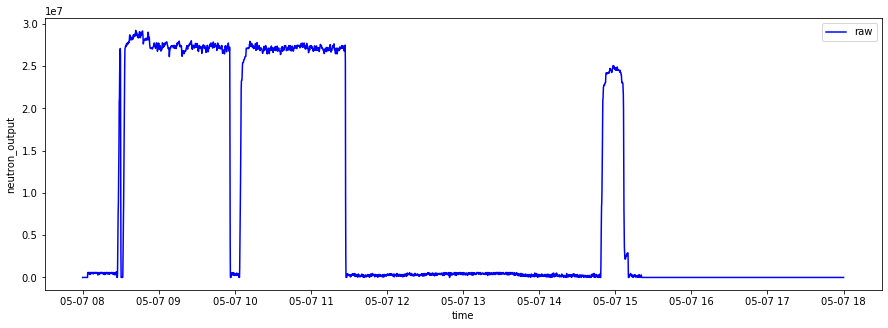

In [31]:
my_date = '2019-5-7'
my_range1 = f'{my_date} 08:00:00'
my_range2 = f'{my_date} 18:00:00'
t = df[ (df['day'] == my_date) ].loc[my_range1:my_range2]

plt.figure(figsize=(15,5))
plt.plot(t['neutron_output'], color='blue', label='raw')


# ax = plt.gca()
# ticks = ax.get_xticks()
# plt.plot(resampled_data['HHMM'], resampled_data['HV_current'], color='red', label='resampled 10s', linewidth=1)

# ax.set_xticks(ticks[::60])
# plt.ylim(0, 3000)
plt.ylabel('neutron_output')
plt.xlabel('time')


plt.legend(loc='best')
plt.show

### Resampling comparison some plots

In [266]:
# testplot = a.set_index('time')
raw_data = df_hv_sample.loc['2017-11-29',['HV_voltage', 'HV_current']].reset_index()
resampled_data = testplot.loc['2017-11-29',['HV_voltage', 'HV_current']].reset_index()

In [201]:
from datetime import datetime
def compute_HHMM(row):
#     print(row)
    return datetime.strftime(row, "%H:%M")

resampled_data['HHMM'] = resampled_data['time'].apply(lambda x: compute_HHMM(x))
raw_data['HHMM'] = raw_data['time'].apply(lambda x: compute_HHMM(x))

<function matplotlib.pyplot.show(*args, **kw)>

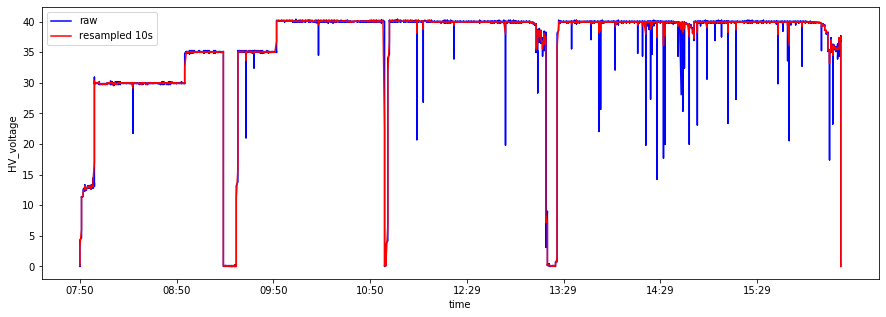

In [210]:
plt.figure(figsize=(15,5))


plt.plot(raw_data['HHMM'], raw_data['HV_voltage'], color='blue', label='raw')

ax = plt.gca()
ticks = ax.get_xticks()
plt.plot(resampled_data['HHMM'], resampled_data['HV_voltage'], color='red', label='resampled 10s')

ax.set_xticks(ticks[::60])
plt.ylabel('HV_voltage')
plt.xlabel('time')


plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

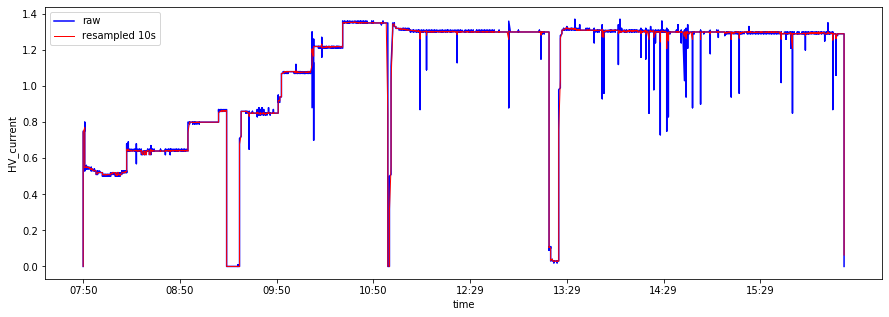

In [213]:
plt.figure(figsize=(15,5))
plt.plot(raw_data['HHMM'], raw_data['HV_current'], color='blue', label='raw')

ax = plt.gca()
ticks = ax.get_xticks()
plt.plot(resampled_data['HHMM'], resampled_data['HV_current'], color='red', label='resampled 10s', linewidth=1)

ax.set_xticks(ticks[::60])
plt.ylabel('HV_current')
plt.xlabel('time')


plt.legend(loc='best')
plt.show

In [356]:
t.head()

,dose,dose_voltage,dose_corrected,day
time,,,,
2019-05-28 00:00:00,0.0,0.0,0.0,2019-5-28
2019-05-28 00:00:10,0.0,0.0,0.0,2019-5-28
2019-05-28 00:00:20,0.0,0.0,0.0,2019-5-28
2019-05-28 00:00:30,0.0,0.0,0.0,2019-5-28
2019-05-28 00:00:40,0.0,0.0,0.0,2019-5-28


<function matplotlib.pyplot.show(*args, **kw)>

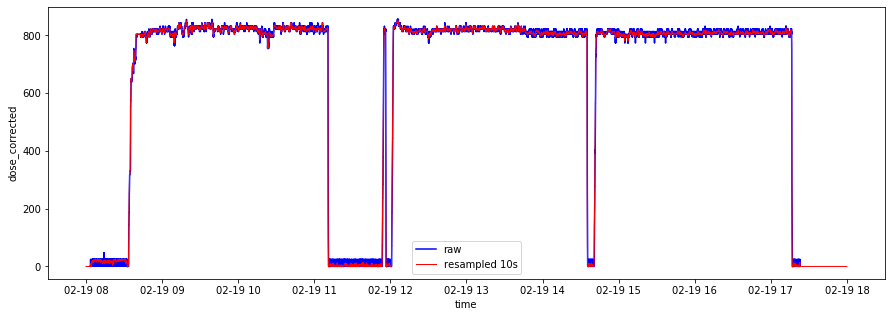

In [365]:
my_date = '2019-2-19'
my_range1 = f'{my_date} 08:00:00'
my_range2 = f'{my_date} 18:00:00'
t = df_dose_resampled[ (df_dose_resampled['day'] == my_date) ].loc[my_range1:my_range2]
t_raw = df_dose[ df_dose['day'] == my_date ].loc[my_range1:my_range2]
plt.figure(figsize=(15,5))
plt.plot(t_raw['dose_corrected'], color='blue', label='raw')
plt.plot(t['dose_corrected'], color='red', label='resampled 10s', linewidth=1)

# ax = plt.gca()
# ticks = ax.get_xticks()
# plt.plot(resampled_data['HHMM'], resampled_data['HV_current'], color='red', label='resampled 10s', linewidth=1)

# ax.set_xticks(ticks[::60])
plt.ylabel('dose_corrected')
plt.xlabel('time')


plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

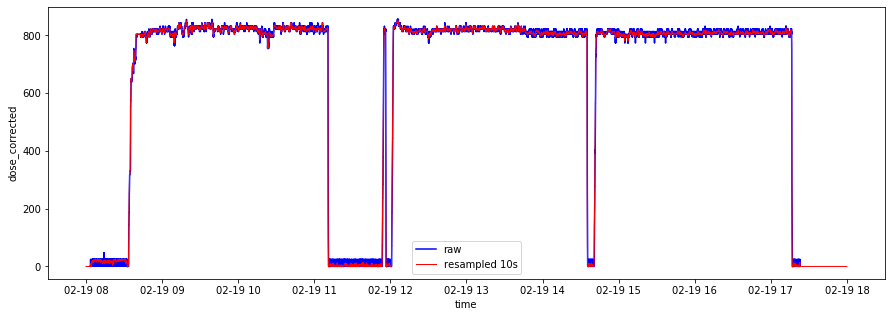

In [384]:
my_date = '2019-2-19'
my_range1 = f'{my_date} 08:00:00'
my_range2 = f'{my_date} 18:00:00'
t = df_out[ (df_out['day'] == my_date) ].loc[my_range1:my_range2]
t_raw = df_dose[ df_dose['day'] == my_date ].loc[my_range1:my_range2]
plt.figure(figsize=(15,5))
plt.plot(t_raw['dose_corrected'], color='blue', label='raw')
plt.plot(t['dose_corrected'], color='red', label='resampled 10s', linewidth=1)

# ax = plt.gca()
# ticks = ax.get_xticks()
# plt.plot(resampled_data['HHMM'], resampled_data['HV_current'], color='red', label='resampled 10s', linewidth=1)

# ax.set_xticks(ticks[::60])
plt.ylabel('dose_corrected')
plt.xlabel('time')


plt.legend(loc='best')
plt.show

In [1]:
df_out.head()

NameError: name 'df_out' is not defined